<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2021-01-02 02:07:55--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.001s  

2021-01-02 02:07:56 (15.8 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

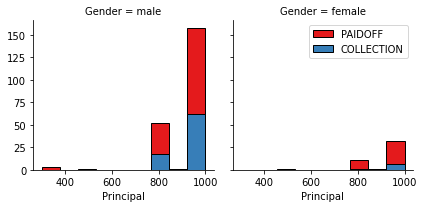

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

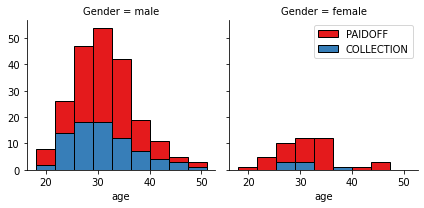

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

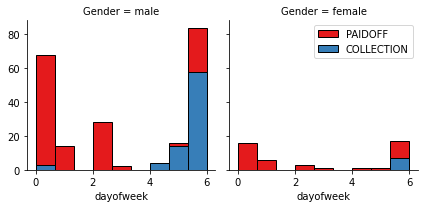

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86.5 % of females pay their loans while only 73.1 % of males pay their loans in this dataset


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1



#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

## One Hot Encoding  
#### Feature before One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to convert categorical variables to binary variables and append them to the feature DataFrame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets define feature set, X

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our labels?

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn. Use the training set to build an accurate model. Then use the test set to report the accuracy of the model. You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**Warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your __train_loan.csv__ into train and test to find the best __k__.

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.2, random_state=4)
print('Train set: ', X_train.shape, y_train.shape)
print('Test set: ', X_test.shape, y_test.shape)

Train set:  (276, 8) (276,)
Test set:  (70, 8) (70,)


In [21]:
#calculate accuracy of KNN for different Ks
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
Ks=10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
for n in range (1, Ks):
    #train and predict
    neigh=KNeighborsClassifier (n_neighbors=n).fit(X_train, y_train)
    kNN_yhat=neigh.predict(X_test)
    mean_acc[n-1]=metrics.accuracy_score(y_test, kNN_yhat)
    std_acc[n-1]=np.std(kNN_yhat==y_test)/np.sqrt(kNN_yhat.shape[0])
mean_acc

print("The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1)

The best accuracy was with 0.7857142857142857 with k= 7


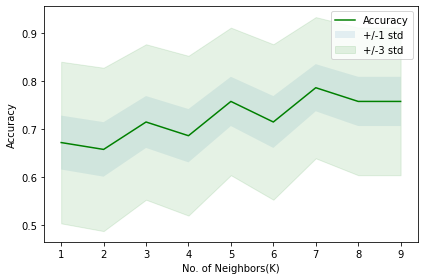

In [22]:
plt.plot(range(1,Ks), mean_acc, 'g')
plt.fill_between(range(1,Ks), mean_acc-1*std_acc, mean_acc+1*std_acc, alpha=0.10)
plt.fill_between(range(1,Ks), mean_acc-3*std_acc, mean_acc+3*std_acc, alpha=0.10, color="green")
plt.legend(('Accuracy', '+/-1 std', '+/-3 std'))
plt.ylabel('Accuracy')
plt.xlabel('No. of Neighbors(K)')
plt.tight_layout()
plt.show()

In [23]:
# running with k=7
k=7
neigh7=KNeighborsClassifier (n_neighbors=k).fit(X_train, y_train)
yhat7=neigh7.predict(X_test)
print('train set acc: ', metrics.accuracy_score(y_train, neigh7.predict(X_train)))
print('test set acc: ', metrics.accuracy_score(y_test, yhat7))

train set acc:  0.8079710144927537
test set acc:  0.7857142857142857


# Decision Tree

In [24]:
from sklearn.tree import DecisionTreeClassifier

In [25]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split (X, y, test_size=0.2, random_state=4)
loantree = DecisionTreeClassifier(criterion="entropy", max_depth=5)
loantree.fit(X_trainset, y_trainset)
DT_yhat = loantree.predict(X_testset)
print("Decision Tree Accuracy: ", metrics.accuracy_score(y_testset, DT_yhat))

Decision Tree Accuracy:  0.6428571428571429


In [26]:
# List of values to try for max_depth:
max_depth_range = list(range(1, 6)) # List to store the average RMSE for each value of max_depth:
accuracy = [] 
for depth in max_depth_range:
    
    ltc = DecisionTreeClassifier(max_depth = depth, random_state = 0)
    ltc.fit(X_trainset, y_trainset)    
    score = ltc.score(X_testset, y_testset)
    accuracy.append(score)
accuracy

[0.7857142857142857,
 0.7857142857142857,
 0.6142857142857143,
 0.6142857142857143,
 0.6285714285714286]

In [27]:
!pip install pydotplus
!pip install graphviz

     |████████████████████████████████| 278 kB 19.4 MB/s eta 0:00:01
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24566 sha256=b682499deed575c98b66270cde99544a2e652c12ae53b6b65f14833d62a2f848
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/1e/7b/04/7387cf6cc9e48b4a96e361b0be812f0708b394b821bf8c9c50
Successfully built pydotplus


[Text(128.01176470588237, 199.32, 'X[4] <= -0.188\nentropy = 0.823\nsamples = 276\nvalue = [71, 205]'),
 Text(39.38823529411765, 163.07999999999998, 'X[7] <= 0.14\nentropy = 0.126\nsamples = 116\nvalue = [2, 114]'),
 Text(19.694117647058825, 126.83999999999999, 'entropy = 0.0\nsamples = 71\nvalue = [0, 71]'),
 Text(59.082352941176474, 126.83999999999999, 'X[2] <= -0.57\nentropy = 0.262\nsamples = 45\nvalue = [2, 43]'),
 Text(39.38823529411765, 90.6, 'entropy = 0.0\nsamples = 15\nvalue = [0, 15]'),
 Text(78.7764705882353, 90.6, 'X[2] <= 1.254\nentropy = 0.353\nsamples = 30\nvalue = [2, 28]'),
 Text(39.38823529411765, 54.359999999999985, 'X[2] <= -0.404\nentropy = 0.25\nsamples = 24\nvalue = [1, 23]'),
 Text(19.694117647058825, 18.119999999999976, 'entropy = 0.592\nsamples = 7\nvalue = [1, 6]'),
 Text(59.082352941176474, 18.119999999999976, 'entropy = 0.0\nsamples = 17\nvalue = [0, 17]'),
 Text(118.16470588235295, 54.359999999999985, 'X[2] <= 1.42\nentropy = 0.65\nsamples = 6\nvalue = [1

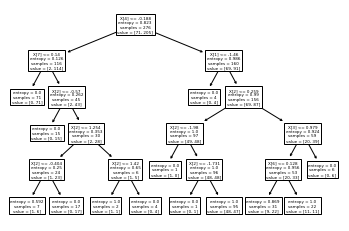

In [28]:
from sklearn import tree
tree.plot_tree(loantree)

# Support Vector Machine

In [29]:
import scipy.optimize as opt
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix

In [30]:
X_trainsvm, X_testsvm, y_trainsvm, y_testsvm = train_test_split (X, y, test_size=0.2, random_state=4)
#modeling
clf=svm.SVC(kernel='rbf')
clf.fit(X_trainsvm, y_trainsvm)
#predict
SVM_yhat=clf.predict(X_testsvm)

              precision    recall  f1-score   support

  COLLECTION       0.36      0.27      0.31        15
     PAIDOFF       0.81      0.87      0.84        55

    accuracy                           0.74        70
   macro avg       0.59      0.57      0.57        70
weighted avg       0.72      0.74      0.73        70

Confusion matrix, without normalization
[[48  7]
 [11  4]]


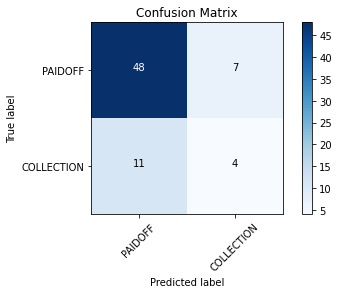

In [31]:
def plot_confusion_matrix (cm, classes, 
                          normalize=False,
                          title='Confusion Matrix',
                           cmap=plt.cm.Blues):
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
#compute confusion matrix
cnf_matrix=confusion_matrix(y_testsvm, SVM_yhat, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)
print(classification_report (y_testsvm, SVM_yhat))

#plot
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'], normalize=False, title='Confusion Matrix')

# Logistic Regression

In [32]:
import scipy.optimize as opt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import jaccard_score, classification_report, confusion_matrix
import itertools

In [33]:
X_training, X_testing, y_training, y_testing = train_test_split (X, y, test_size=0.2, random_state=4)
LR=LogisticRegression(C=0.01, solver='liblinear').fit(X_training, y_training) #alt solver='sag'
LR_yhat=LR.predict(X_testing)
LR_yhat_prob=LR.predict_proba(X_testing)
print("Jaccard score of PAIDOFF: ", jaccard_score(y_testing, LR_yhat, pos_label="PAIDOFF")) 

Jaccard score of PAIDOFF:  0.6764705882352942


In [34]:
LR2=LogisticRegression(C=0.01, solver='sag').fit(X_training, y_training) 
LR2_yhat=LR2.predict(X_testing)
LR2_yhat_prob=LR2.predict_proba(X_testing)
print("Jaccard score of PAIDOFF: ", jaccard_score(y_testing, LR2_yhat, pos_label="PAIDOFF")) 

Jaccard score of PAIDOFF:  0.7857142857142857


# Model Evaluation using Test set

In [35]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [36]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-01-02 02:08:04--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-01-02 02:08:04 (88.0 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [37]:
test_df = pd.read_csv('loan_test.csv')
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df[['Principal','terms','age','Gender','education']]

test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
test_Feature = pd.concat([test_Feature,pd.get_dummies(test_df['education'])], axis=1)
test_Feature.drop(['Master or Above'], axis = 1,inplace=True)

test_X=test_Feature
test_X=preprocessing.StandardScaler().fit(test_X).transform(test_X)

test_y=test_df['loan_status'].values

#test_df['loan_status'].value_counts()
print('Test set: ', test_X.shape, test_y.shape)

Test set:  (54, 8) (54,)


In [38]:
# kNN accuracy
# y of loan_test and pred y using test_X...update: 
kNN_test_yhat = neigh.predict(test_X)
print("kNN Accuracy")
print("Jaccard score of PAIDOFF: ", jaccard_score(test_y, kNN_test_yhat, pos_label="PAIDOFF"))
print("Avg f1 score: %.4f"% f1_score (test_y, kNN_test_yhat, average='weighted'))

kNN Accuracy
Jaccard score of PAIDOFF:  0.6862745098039216
Avg f1 score: 0.6736


In [40]:
# decision tree accuracy
# y of loan_test and pred y using test_X...update: 
DT_test_yhat = loantree.predict(test_X)
print("Decision Tree Accuracy")
print("Jaccard score of PAIDOFF: ", jaccard_score(test_y, DT_test_yhat, pos_label="PAIDOFF"))
print("Avg f1 score: %.4f"% f1_score (test_y, DT_test_yhat, average='weighted'))

Decision Tree Accuracy
Jaccard score of PAIDOFF:  0.6904761904761905
Avg f1 score: 0.7733


In [41]:
# SVM accuracy
# y of loan_test and pred y using test_X...update: 
SVM_test_yhat=clf.predict(test_X)
print("SVM Accuracy")
print("Jaccard score of PAIDOFF: ", jaccard_score(test_y, SVM_test_yhat, pos_label="PAIDOFF"))
print("Avg f1 score: %.4f"% f1_score (test_y, SVM_test_yhat, average='weighted'))

SVM Accuracy
Jaccard score of PAIDOFF:  0.78
Avg f1 score: 0.7584


In [43]:
# logistic regression accuracy
# y of loan_test and pred y using test_X...update: 
LR2_test_yhat_prob=LR2.predict_proba(test_X)
LR2_test_yhat=LR2.predict(test_X)
print("Logistic Regression Accuracy")
print("Jaccard score of PAIDOFF: ", jaccard_score(test_y, LR2_test_yhat, pos_label="PAIDOFF"))
print("Avg f1 score: %.4f"% f1_score (test_y, LR2_test_yhat, average='weighted'))
print ("LogLoss: : %.2f"% log_loss(test_y, LR2_test_yhat_prob))

Logistic Regression Accuracy
Jaccard score of PAIDOFF:  0.7407407407407407
Avg f1 score: 0.6304
LogLoss: : 0.52


# Report
Reporting the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard     | F1-score     | LogLoss    |
|--------------------|-------------|--------------|------------|
| KNN                | 0.686       | 0.674        | NA         |
| Decision Tree      | 0.691       | 0.773        | NA         |
| SVM                | 0.780       | 0.758        | NA         |
| LogisticRegression | 0.741       | 0.630        | 0.52       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>